# SVBench

## Load reference calls

This notebook will demonstrate how svbench can be used to benchmark SV calls using the HG002 sample.
We will use a reference call set from GIAB: [HG002](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1_v0.6.vcf.gz)
We will analyse qurty calls made using the variant callers dysgu, manta and delly. These callers were run on the HG002 sample sequenced using Illumina 148bp paired-end reads at 40X coverage. 
For convenience, we will utilize an input folder `"../svbench_demo"` and place reference and query SV calls there. 

The first step is to load the reference calls into a CallSet object. CallSet objects are labelled with a dataset name, in this case "HG002". The load_vcf function parses the reference file using the pyvcf library and stores the result in a pandas dataframe. Input columns of interest can be selectively parsed, in this example we are selecting to keep the "FILTER" column from the input file. The 'other_cols' parameter can take a list of columns to parse from the input file. These can be specified in string format, or using svb.Col object (more on this below). If you want all the data in the vcf file to be parsed into the dataframe, `other_cols="all"` can be used.

In [1]:
import svbench as svb
from svbench import CallSet, Col


# Input is in vcf format, but bed and bedpe are also possible
hg002 = CallSet(dataset="HG002").\
            load_vcf("../svbench_demo/HG002_SVs_Tier1_v0.6.vcf.gz", other_cols=["FILTER"])



dataset=HG002, caller=None, loaded rows: 74012
columns: ['chrom', 'start', 'chrom2', 'end', 'svtype', 'w', 'id', 'size_filter_pass', 'svlen', 'FILTER']
n not in include: 0


The pandas dataframe can be accessed using the 'breaks_df' attribute, for example:

In [2]:
hg002.breaks_df.head()

,chrom,start,chrom2,end,svtype,w,id,size_filter_pass,svlen,FILTER
0,chr1,10403,chr1,10440,DEL,None,HG2_Ill_svaba_2,True,37,[LongReadHomRef]
1,chr1,10415,chr1,10440,DEL,None,HG3_Ill_GATKHC_3,True,25,[LongReadHomRef]
2,chr1,10616,chr1,10637,DEL,None,HG4_Ill_GATKHC_3,True,21,[NoConsensusGT]
3,chr1,54712,chr1,54712,INS,None,HG2_Ill_250bpfermikitraw_2,True,53,[NoConsensusGT]
4,chr1,385977,chr1,385977,INS,None,HG2_PB_PB10Xdip_2154,True,74,[NoConsensusGT]


The HG002 reference set can be split into different tiers, with Tier1 calls representing the highest quality/most confident genomic regions. In this example we will select the
Tier1+2 regions using the bed file provided by GIAB [link is here](ftp://ftp-trace.ncbi.nlm.nih.gov/giab/ftp/data/AshkenazimTrio/analysis/NIST_SVs_Integration_v0.6/HG002_SVs_Tier1plusTier2_v0.6.1.bed)

The reference calls can be filtered using the `filter_include_bed` function:

In [3]:
tier1_2 = hg002.filter_include_bed("../svbench_demo/HG002_SVs_Tier1plusTier2_v0.6.1.bed")

dataset=None, caller=None, loaded rows: 23901
Filtered by include_bed, caller=None, dataset=HG002 rows before 74012, after 40742


Finally we will add intervals around each break point, this is needed when comparing query calls to this reference set. Here we add 250 bp intervals around each break point:

In [4]:
tier1_2 = tier1_2.add_intervals(slop=250)

## Load query calls

Next we will load calls made using dysgu, manta and delly. For convenience there are loading functions for some of the popular structural variant callers. However, query vcf files are parsed in the same way as the reference calls, so a custom loading function can also be written:

In [5]:
from svbench import load_dysgu, load_manta, load_delly

dysgu = load_dysgu("../svbench_demo/HG002.dysgu.vcf", dataset="HG002")
manta = load_manta("../svbench_demo/HG002.manta.diploidSV.vcf", dataset="HG002")
delly = load_delly("../svbench_demo/HG002.delly.vcf", dataset="HG002")

Loading dysgu, stratified using svbench.Col(add=None col=FORMAT, key=PROB, encoding=None, bins=[0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5   0.525 0.55  0.575
 0.6   0.625 0.65  0.675 0.7   0.725 0.75  0.775 0.8   0.825 0.85  0.875
 0.9   0.925 0.95  0.975 1.   ], norm=None, op=None, thresh=None), keep records with svbench.Col(add=None col=FILTER, key=None, encoding=None, bins=None, norm=None, op=eq, thresh=None)
dataset=HG002, caller=dysgu, loaded rows: 18129
columns: ['chrom', 'start', 'chrom2', 'end', 'svtype', 'w', 'strata', 'id', 'size_filter_pass', 'svlen']
n not in include: 0
Loading manta, stratified using svbench.Col(add=None col=QUAL, key=None, encoding=None, bins=range(0, 1500, 50), norm=None, op=None, thresh=None), keep records with svbench.Col(add=None col=FILTER, key=None, encoding=None, bins=None, norm=None, op=eq, thresh=None)
dataset=HG002, caller=manta, loaded rows: 8436
columns: ['chrom

### Manually loading a vcf file
To demonstrate how the default loading options can be changed, or to load a new file from a novel caller, we will re-load the calls from delly using the `load_vcf` function:

In [6]:

delly_v2 = CallSet(dataset="HG002", caller="delly_DP").\
            load_vcf("../svbench_demo/HG002.delly.vcf",
                     stratify=Col("FORMAT", "DP", bins=range(0, 100, 2)),
                     keep=[Col("FILTER", op="eq", thresh=None)])

dataset=HG002, caller=delly_DP, loaded rows: 14498
columns: ['chrom', 'start', 'chrom2', 'end', 'svtype', 'w', 'strata', 'id', 'size_filter_pass', 'svlen']
n not in include: 0


The main difference compared with loading the reference calls, is that `stratify` and `keep` arguments are used. The `stratify` argument tells svbench how to bin variants into different strata which is needed for plotting a precison-recall curve. This is achived by using a `Col` object:

In [7]:
Col("FORMAT", "DP", bins=range(0, 100, 2))

svbench.Col(add=None col=FORMAT, key=DP, encoding=None, bins=range(0, 100, 2), norm=None, op=None, thresh=None)

This specifies that in the `"FORMAT"` field, the `"DP"` column will be used, and the bin values will be `bins=range(0, 100, 2))`. Likewise input calls are also filtered during loading by using the `keep` argument:

In [8]:
Col("FILTER", op="eq", thresh=None)

svbench.Col(add=None col=FILTER, key=None, encoding=None, bins=None, norm=None, op=eq, thresh=None)

Here only records without a filter applied will be loaded. The `op="eq"` argument will apply a test of equality with `thresh=None`. For example, another option might be to filter calls with `DP` > 3 reads, this could be achived using `keep=Col("FORMAT", "DP", op="gt", thresh=3)` 

## Manually filtering a CallSet 
Vcf records are converted to a pandas DataFrame internally. The DataFrame can be accessed using:

In [9]:
delly.breaks_df

,chrom,start,chrom2,end,svtype,w,strata,id,size_filter_pass,svlen
0,chrM,2,chrM,16202,DUP,None,10000.0,DUP00000000,True,16200
1,chrM,10266,chrM,10649,INV,None,88.0,INV00000009,True,383
2,chrM,12868,chrM,14978,INV,None,544.0,INV00000012,True,2110
3,chrM,13442,chrM,15488,INV,None,161.0,INV00000013,True,2046
4,chrM,14300,chrM,14540,DEL,None,81.0,DEL00000014,True,240
...,...,...,...,...,...,...,...,...,...,...
14493,chrUn_gl000234,37525,chrUn_gl000234,37765,DEL,None,762.0,DEL00046232,True,240
14494,chrUn_gl000236,6330,chrUn_gl000236,6366,DEL,None,237.0,DEL00046248,True,36
14495,chrUn_gl000237,9046,chrUn_gl000237,9079,DEL,None,845.0,DEL00046257,True,33
14496,chrUn_gl000239,27550,chrUn_gl000239,27991,DUP,None,569.0,DUP00046262,True,441


Svbench supports a thin wrapper around the pandas DataFrame [query](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.query.html) function. For example, we can filter for deletion calls > 300 bp:

In [10]:
delly_v2 = delly_v2.query("svtype.str.match('DEL') and svlen>=300")

Filtered by expression, caller=delly_DP, dataset=HG002 rows before 14498, after 3477


## Comparing query vs reference calls
First we will put our query calls in a list. Then we will filter query calls that overlap Tier1+2 regions, as we did your the reference calls:

In [11]:
callers = [dysgu, manta, delly]
for c in callers:
    c.filter_include_bed("../svbench_demo/HG002_SVs_Tier1plusTier2_v0.6.1.bed", inplace=True)

dataset=None, caller=None, loaded rows: 23901
Filtered by include_bed, caller=dysgu, dataset=HG002 rows before 18129, after 10554
dataset=None, caller=None, loaded rows: 23901
Filtered by include_bed, caller=manta, dataset=HG002 rows before 8436, after 7390
dataset=None, caller=None, loaded rows: 23901
Filtered by include_bed, caller=delly, dataset=HG002 rows before 14498, after 6270


Next query calls are compared to a reference set using the `score` function:

In [12]:
svb.score(tier1_2, callers)

Scoring dataset=HG002 caller=dysgu
Score table caller=dysgu against dataset=HG002
Scores:
   T >=    Ref  Total    TP   FP  DTP     FN  Duplication  Precision  Recall      F1
0  None  40742  10554  9893  461  200  30849     0.020216     0.9555  0.2428  0.3872
Scores over side ranges:
     Ref size ranges    TP   FP  Precision    Recall        F1
0           [30, 50)  1651   66   0.961561  0.266893  0.417816
1          [50, 500)  6177  237   0.963050  0.301729  0.459496
2        [500, 5000)  1223  144   0.894660  0.253945  0.395601
3  [5000, 260000000)   206   14   0.936364  0.399225  0.559783
4         All ranges  9257  461   0.952562  0.289372  0.443896
---------------------------------------------
Scoring dataset=HG002 caller=manta
Score table caller=manta against dataset=HG002
Scores:
   T >=    Ref  Total    TP   FP  DTP     FN  Duplication  Precision  Recall      F1
0  None  40742   7390  6886  309  195  33856     0.028318     0.9571   0.169  0.2873
Scores over side ranges:
     R

The results can be interrogated in a few ways. Each query callset will have a `scores` attribute that has been filled out:

In [13]:
dysgu.scores

,T >=,Ref,Total,TP,FP,DTP,FN,Duplication,Precision,Recall,F1
0,None,40742,10554,9893,461,200,30849,0.020216,0.9555,0.2428,0.3872


Alternatively records in the DataFrame are labelled: 

In [14]:
dysgu.breaks_df.head()

,chrom,start,chrom2,end,svtype,w,strata,id,size_filter_pass,svlen,TP,DTP,ref_index,FP,ref_size
0,chr1,54720,chr1,54720,INS,None,0.531,3,True,54,True,False,3.0,False,53.0
1,chr1,66452,chr1,66452,INS,None,0.606,7,True,54,False,False,NaN,True,NaN
2,chr1,756259,chr1,756259,INS,None,0.642,33,True,434,True,False,10.0,False,244.0
3,chr1,821604,chr1,821605,INS,None,0.645,46,True,30,True,False,17.0,False,30.0
4,chr1,829171,chr1,829207,DEL,None,0.929,54,True,36,True,False,18.0,False,36.0


Also the missing reference calls are given by a set of indexes, here we convert to a list and show the first 3 indexes:

In [15]:
fn = list(dysgu.false_negative_indexes)
fn[:3]

[2, 4, 6]

The corresponding reference calls can be collected using:

In [18]:
tier1_2.breaks_df.loc[dysgu.false_negative_indexes]

,chrom,start,chrom2,end,svtype,w,id,size_filter_pass,svlen,FILTER
2,chr1,10616,chr1,10637,DEL,None,HG4_Ill_GATKHC_3,True,21,[NoConsensusGT]
4,chr1,385977,chr1,385977,INS,None,HG2_PB_PB10Xdip_2154,True,74,[NoConsensusGT]
6,chr1,532077,chr1,532177,DEL,None,HG2_PB_SVrefine2PB10Xhap12_3,True,100,[NoConsensusGT]
8,chr1,645959,chr1,645959,INS,None,HG2_PB_PB10Xdip_2549,True,319,[NoConsensusGT]
9,chr1,724861,chr1,724861,INS,None,HG2_Ill_breakscan11_2919,True,2358,[NoConsensusGT]
...,...,...,...,...,...,...,...,...,...,...
74007,chrY,59002942,chrY,59002942,INS,None,HG4_PB_HySA_29505,True,61,[NoConsensusGT]
74008,chrY,59004477,chrY,59004690,DEL,None,HG2_Ill_GATKHCSBGrefine_13224,True,213,[NoConsensusGT]
74009,chrY,59013741,chrY,59013741,INS,None,HG3_PB_SVrefine2PBcRDovetail_10185,True,133,[NoConsensusGT]
74010,chrY,59019531,chrY,59019553,DEL,None,HG2_Ill_scalpel_18829,True,22,[NoConsensusGT]


## Plotting results
Svbench provides a function for plotting a precision vs true positive (TP) curve:

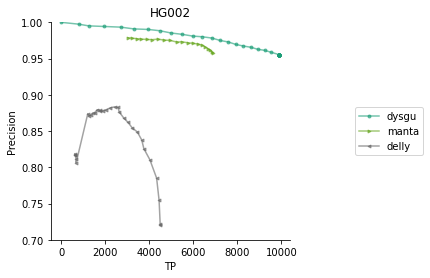

{'HG002': <module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>}

In [19]:
svb.plot(callers, ylim=(0.7, 1), x="TP", y="Precision")

Finally, we filter for insertion calls and plot the results. Note, the `add_intervals` function must be called again as the old intervals will point to records that have been filtered out:

In [20]:
callers = [dysgu, manta, delly]
callers = [i.filter_by_svtype("INS") for i in callers]
hg002.filter_by_svtype("INS").add_intervals(slop=250)
svb.score(hg002, callers)

Filtered by svtype, caller=dysgu, dataset=HG002 rows before 10554, after 4765
Filtered by svtype, caller=manta, dataset=HG002 rows before 7390, after 2655
Filtered by svtype, caller=delly, dataset=HG002 rows before 6270, after 371
Filtered by svtype, caller=None, dataset=HG002 rows before 74012, after 36600
Scoring dataset=HG002 caller=dysgu
Score table caller=dysgu against dataset=HG002
Scores:
   T >=    Ref  Total    TP   FP  DTP     FN  Duplication  Precision  Recall      F1
0  None  36600   4765  4430  257   78  32170     0.017607     0.9452   0.121  0.2145
Scores over side ranges:
     Ref size ranges    TP   FP  Precision    Recall        F1
0           [30, 50)   698   35   0.952251  0.093918  0.170974
1          [50, 500)  2764  218   0.926895  0.233052  0.372457
2        [500, 5000)   504    4   0.992126  0.151853  0.263392
3  [5000, 260000000)    42    0   1.000000  0.166008  0.284746
4         All ranges  4008  257   0.939742  0.175297  0.295477
----------------------------

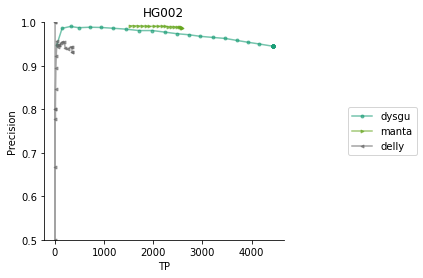

{'HG002': <module 'matplotlib.pyplot' from '/opt/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>}

In [22]:
svb.plot(callers, ylim=(0.5, 1), x="TP", y="Precision")